# Some cool title

#### Zack Peachell, Jasper Palov, Arjun Saxena, Bhavya Dubey

## Introduction

## Our Methods and Results

Before starting our analysis we need to load in several packages in order to have most of our functions work in the R language.

In [1]:
#This cell must be run to continue
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)
options(repr.plot.width = 4, repr.plot.height = 4)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

The dataset we are using has to be read in from the repository in a relative path, so that we can start manipulating it to reach our conclusion, and to avoid any confusion associated with an absolute path.

In [2]:
star_raw_data <- "https://raw.githubusercontent.com/zackpeachell/DSCI_100_008_05_project/main/6%20class%20csv.csv"
read_star <- read_csv(star_raw_data)
read_star

Rows: 240 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Star color, Spectral Class
dbl (5): Temperature (K), Luminosity(L/Lo), Radius(R/Ro), Absolute magnitude...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
3068,0.0024,0.1700,16.12,0,Red,M
3042,0.0005,0.1542,16.60,0,Red,M
2600,0.0003,0.1020,18.70,0,Red,M
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8829,537493,1423,-10.73,5,White,A
9235,404940,1112,-11.23,5,White,A
37882,294903,1783,-7.80,5,Blue,O


While although this dataset looks tidy, the names of the columns prove to be quite challenging to work with when in R, and therefore will be changed to remove brackets and spaces. As well we will remove any "non-applicable" values for both spectral class and star type, as those will be the primary concern for the classification. Also since star type is currently a data value with a decimal, we will change it to a factor for easy analysis. 

In [3]:
#these columns need renames

name_star <- read_star|>
                rename("Star_type" = "Star type")|>
                rename("Temperature_K" = "Temperature (K)")|>
                rename("Star_color" = "Star color")|>
                rename("Spectral_Class" = "Spectral Class")|>
                rename("Luminosity_ratio" = "Luminosity(L/Lo)")|>
                rename("Radius_ratio" = "Radius(R/Ro)")|>
                rename("Absolute_magnitude_Mv" = "Absolute magnitude(Mv)")|>
                filter(Spectral_Class != "NA")|>
                filter(Star_type != "NA")|>
                mutate(Star_type = as_factor(Star_type))


We should summarize the data to show the relative amounts of each star type and spectral class, as one is most likely to be better suited for classification than another, and we want an almost even spread amongst each character/factor.

In [14]:
set.seed(9999)
star_spectral_count <- name_star|>
                group_by(Spectral_Class)|>
                summarize(count = n())
star_spectral_count

star_type_count <- name_star|>
                    group_by(Star_type)|>
                    summarize(count = n())

star_type_count

Spectral_Class,count
<chr>,<int>
A,19
B,46
F,17
⋮,⋮
K,6
M,111
O,40


Star_type,count
<fct>,<int>
0,40
1,40
2,40
3,40
4,40
5,40


So this is a clear indicator that star type should be analyzed for as it has an even spread of values, making it suitable and a good variable to determine for classification, and we can proceed to the next steps. First must reduce our original dataset in order to only use variables we would consider to be helpful, and therefore we will remove the spectral class, star color, and luminosity ratio (has a correlation to the absolute magnitude) from the data. We can then setup a training and testing dataset.

In [5]:
select_star <- name_star|>
                select(-Spectral_Class, -Luminosity_ratio, -Star_color)

set.seed(9999)
split_star <- initial_split(select_star, prop = 0.75, strata = Star_type)
train_star <- training(split_star)
test_star <- testing(split_star)
train_star

Temperature_K,Radius_ratio,Absolute_magnitude_Mv,Star_type
<dbl>,<dbl>,<dbl>,<fct>
3068,0.1700,16.12,0
3042,0.1542,16.60,0
2600,0.1020,18.70,0
⋮,⋮,⋮,⋮
30839,1194,-10.63,5
8829,1423,-10.73,5
37882,1783,-7.80,5


This data must be scaled or it will not be of any use to us, as some values are extremely large. We can then visualize the relationship between two variables and star type using a scatterplot.

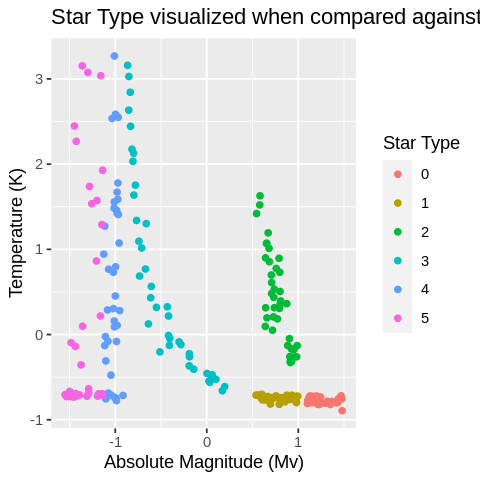

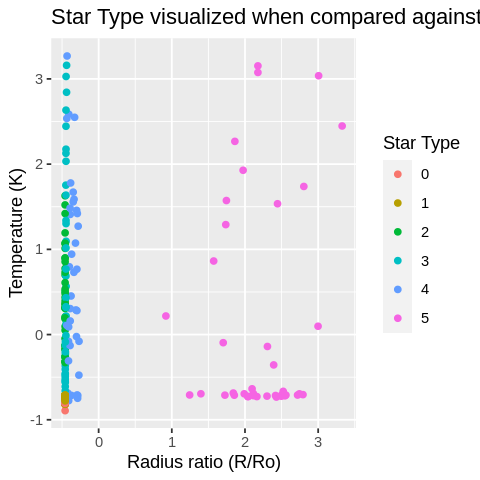

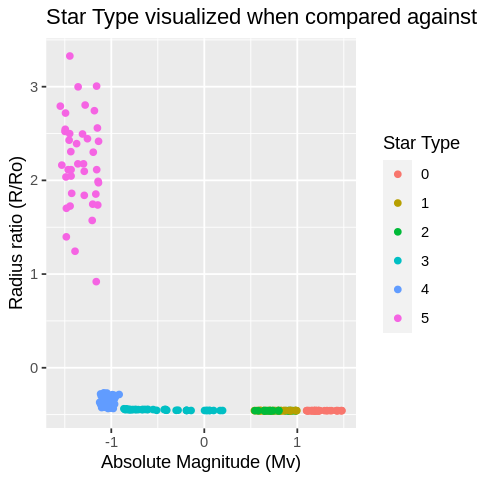

In [6]:
set.seed(9999)

star_recipe <- recipe(Star_type ~ Temperature_K + Radius_ratio + Absolute_magnitude_Mv, data = train_star)|>
                    step_scale(all_predictors())|>
                    step_center(all_predictors())|>
                    prep()
star_scale <- bake(star_recipe, name_star)

#options(repr.width.plot = 5, repr.height.plot = 5)
star_recipe_plot_1 <- star_scale|>
                    ggplot(aes(x = Absolute_magnitude_Mv, y = Temperature_K))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Absolute Magnitude (Mv)")+
                    ylab("Temperature (K)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Temperature and Absolute magnitude")+
                    scale_fill_brewer(palette = "Set2")
star_recipe_plot_2 <- star_scale|>
                    ggplot(aes(x = Radius_ratio, y = Temperature_K))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Radius ratio (R/Ro)")+
                    ylab("Temperature (K)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Temperature and the Radius ratio")+
                    scale_fill_brewer(palette = "Set2")
star_recipe_plot_3 <- star_scale|>
                    ggplot(aes(x = Absolute_magnitude_Mv, y = Radius_ratio))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Absolute Magnitude (Mv)")+
                    ylab("Radius ratio (R/Ro)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Radius ratio and Absolute magnitude")+
                    scale_fill_brewer(palette = "Set2")
star_recipe_plot_1
star_recipe_plot_2
star_recipe_plot_3

The first set of the classification process is to determine a reasonable value for k, which can yield the greatest accuracy for when we test against the testing data. Tuning and cross-validation must be performed on the tetsing data to determine a good value for the nearst neighbors. Some assumptions include that a 5 fold cross-validation will be performed and that k values from 2 to 10 will be tested only. There will be little effect present on the overall accuracy of the model. The metrics of this workflow we create will be analyzed to determine the best k value

In [7]:
set.seed(9999)

kknn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
                    set_engine("kknn")|>
                    set_mode("classification")

star_vfold <-vfold_cv(train_star, v = 5, strata = Star_type)

k_vals <- tibble(neighbors = seq(from = 2, to = 10, by = 1))

star_workflow <- workflow()|>
                    add_recipe(star_recipe)|>
                    add_model(kknn_tune)|>
                    tune_grid(resamples = star_vfold, grid = k_vals)|>
                    collect_metrics()
star_workflow

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.9944444,5,0.005555556,Preprocessor1_Model1
2,roc_auc,hand_till,0.9985185,5,0.001079806,Preprocessor1_Model1
3,accuracy,multiclass,0.9722222,5,0.008784105,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,hand_till,0.9971296,5,0.001137797,Preprocessor1_Model8
10,accuracy,multiclass,0.9611111,5,0.014163943,Preprocessor1_Model9
10,roc_auc,hand_till,0.9962963,5,0.001085744,Preprocessor1_Model9


Now that we have done this workflow, we should extract the neighbors and there relative accuracy, hidden in the "mean" column, to determine which k gives the greatest accuracy for our classification model. We can also visualize this as a graph of neighbors vs accuracy, using a line graph, to determine which k value returns the greatest accuracy from the vfold splitting.

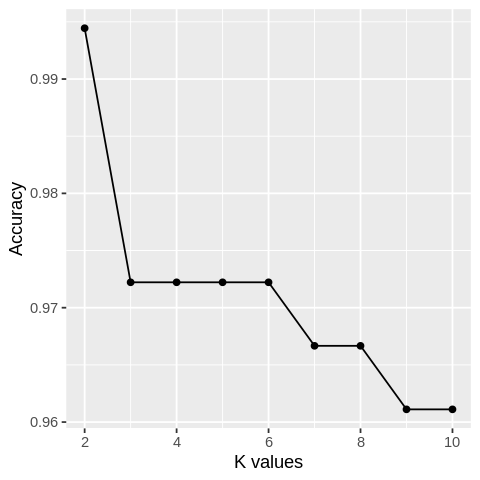

In [8]:
set.seed(9999)

accuracies <- star_workflow |>
                filter(.metric == "accuracy")
options(repr.plot.height = 4, repr.plot.width = 4)
best_k_plot <- accuracies |>
                ggplot(aes(x = neighbors, y = mean))+
                geom_point()+
                geom_line()+
                xlab("K values")+
                ylab("Accuracy")
best_k_plot

This graph best desrcibes that accuracy is really high when using k = 2 as it is almost a hundred percent accurate. Using this k value, the workflow should be redesigned using this k value so we can test the accuracy against new data, the test data. The same star recipe will be used from before as nothing changes and we need that recipe in order to test the testing data.

In [9]:
set.seed(9999)

best_k <- 2

best_kknn <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k)|>
                set_engine("kknn")|>
                set_mode("classification")

best_fit <- workflow()|>
                add_recipe(star_recipe)|>
                add_model(best_kknn)|>
                fit(data = train_star)

best_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02222222
Best kernel: rectangular
Best k: 2

We have now created the most accuarate workflow using the best k value, we can predict and test the accuracy against the testing data, using the predict and metric functions to achieve this goal. Then the result can be filtered to give a column of the accuracy of the model.

In [13]:
set.seed(9999)
star_predictions <- predict(best_fit, test_star)|>
                        bind_cols(test_star)

star_accuracies <- star_predictions|>
                     metrics(truth = Star_type, estimate = .pred_class)|>
                      filter(.metric == "accuracy")  

star_accuracies

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9833333


This proves that our classifier is very accurate, near 100 percent, and we should move to test a point that we know the class for but isn't part of this dataset, to see if it holds up with our classification model.

In [11]:
set.seed(9999)
new_obs_1 <- tibble(Temperature_K = 5800, Radius_ratio = 0.0127811127, Absolute_magnitude_Mv = 15.429, Star_type = NA)

kknn_predict_1 <- predict(best_fit, new_obs_1)
kknn_predict_1

.pred_class
<fct>
2


In [ ]:
set.seed(9999)
star_recipe_plot_obs_1 <- name_star|>
                    ggplot(aes(x = Absolute_magnitude_Mv, y = Temperature_K))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Absolute Magnitude (Mv)")+
                    ylab("Temperature (K)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Temperature and Absolute magnitude")+
                    scale_fill_brewer(palette = "Set2")

star_recipe_plot_obs_2 <- name_star|>
                    ggplot(aes(x = Absolute_magnitude_Mv, y = Radius_ratio))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Absolute Magnitude (Mv)")+
                    ylab("Radius ratio (R/Ro)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Radius ratio and Absolute magnitude")+
                    scale_fill_brewer(palette = "Set2")

star_recipe_plot_obs_3 <- name_star|>
                    ggplot(aes(x = Radius_ratio, y = Temperature_K))+
                    geom_point(aes(colour = Star_type))+
                    xlab("Radius ratio (R/Ro)")+
                    ylab("Temperature (K)")+
                    labs(colour = "Star Type")+
                    ggtitle("Star Type visualized when compared against Temperature and Absolute magnitude")+
                    scale_fill_brewer(palette = "Set2")

star_recipe_plot_obs_1 <- star_recipe_plot_obs_1+
                            geom_point(aes(x = 15.429, y = 5800), colour = "black", size = 2)
star_recipe_plot_obs_2 <- star_recipe_plot_obs_2+
                            geom_point(aes(x = 15.429, y = 0.0127811127), colour = "black", size = 2)
star_recipe_plot_obs_3 <- star_recipe_plot_obs_3+
                            geom_point(aes(x = 0.0127811127, y = 5800), colour = "black", size = 2)

star_recipe_plot_obs_1
star_recipe_plot_obs_2
star_recipe_plot_obs_3

#maybe I will include another example point and reduce graphs to just 1, i.e two of these below are useless, just a suggestion!

## Discussion of Results

## References

Deepraj Baidya. 2019. Star dataset to predict star types. Retrieved October 24th 2023 from https://www.kaggle.com/datasets/deepu1109/star-dataset/data